# ATP Tennis Data



# Summary of Results






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, RSTATE, N_JOBS, MAX_ITER, LABEL_COL
import util.model_util as mu
import logging
import importlib

logging.basicConfig(level=logging.INFO)
%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d %H:%m'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "raw-ohe"


# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    DESCRIPTION = f"{DESCRIPTION}-test"
    FEATURE_FILE = '../datasets/atp_matches_1985-2019_features_test-raw_diff-ohe-history-matchup-stats.csv'
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
else:
    FEATURE_FILE = '../datasets/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv'




START_YEAR = 1998
END_YEAR = 2018


In [2]:
data = pd.read_csv(FEATURE_FILE)

# Run all Models

In [3]:
column_filters = ["util.model_util.ReducedOrdinalFilter", "util.model_util.OHEFilter"]

models = [
#     LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
#     KNeighborsClassifier(n_jobs = N_JOBS),
#     DecisionTreeClassifier(random_state = RSTATE),
#     RandomForestClassifier(random_state=RSTATE, verbose=1),
    GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
#     AdaBoostClassifier(random_state=RSTATE),
]

INFO:util.model_util:Adding filter: util.model_util.ReducedOrdinalFilter
INFO:util.model_util:Adding filter: util.model_util.OHEFilter
INFO:util.model_util:Copying features dataframe
INFO:util.model_util:Shape before filtering: (118478, 5464)
INFO:util.model_util:Shape after filtering: (118478, 5254)
INFO:util.model_util:Final Features shape: (118478, 5254)


Final columns: Index(['tourney_level_label', 'tourney_year', 'p1_age', 'p1_ht', 'p1_rank',
       'p2_age', 'p2_ht', 'p2_rank', 'best_of_3', 'best_of_5',
       ...
       'tourney_id_m010', 'tourney_id_m014', 'tourney_id_m015',
       'tourney_id_m016', 'tourney_id_m020', 'tourney_id_m021',
       'tourney_id_m024', 'tourney_id_m035', 'tourney_id_m052',
       'tourney_id_o16'],
      dtype='object', length=5254)


Running GradientBoostingClassifier
      Iter       Train Loss   Remaining Time 
         1           1.3665           21.44m
         2           1.3496           21.12m
         3           1.3349           20.83m
         4           1.3227           20.68m
         5           1.3119           20.48m
         6           1.3028           20.22m
         7           1.2949           19.97m
         8           1.2882           20.03m
         9           1.2821           20.06m
        10           1.2769           20.06m
        20           1.2344           17.89m
    

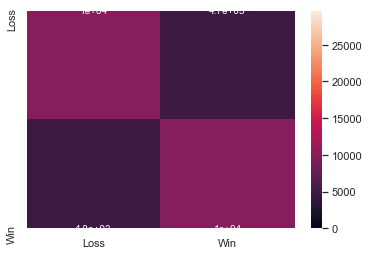

In [4]:
for model in models:
    X_train, X_test, y_train, y_test = ModelWrapper.get_data(data, LABEL_COL, START_YEAR, END_YEAR, column_filters = column_filters)
    print(f'Final columns: {X_test.columns}')
    
    print(f'\n\nRunning {type(model).__name__}')
    mw = mu.ModelWrapper(model,
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                    column_filters = column_filters)
    mw.fit(X_train, y_train)
    predict = mw.predict(X_test)
    mw.analyze(y_test)
    plt.show()
#     mw.save()

# Summary

In [5]:
# report = pd.read_csv(ModelWrapper.REPORT_FILE)

# f, a = plt.subplots(1, 1, figsize=(20, 10))

# descs = report.description.unique()

# for desc in descs:
#     report_desc = report[report.description == desc]
#     if desc == DESCRIPTION:
#         sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
#     else:
#         sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

# a.axhline(0.65, ls='--', color='r')
# a.set_title(f"Model Accuracy")
# _ = a.legend(loc="lower left")

In [6]:
# best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
# print(f'Best Model: {best_model}')

# dt_report = report[(report.model_name == 'GradientBoostingClassifier')]

# f, a = plt.subplots(1, 1, figsize=(20, 5))
# _ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
# _ = a.axhline(0.65, ls='--', color='r')
# _ = a.set_label(f"{best_model} Accuracy")
# _ = plt.xticks(rotation=45)


# SHAP VALUES

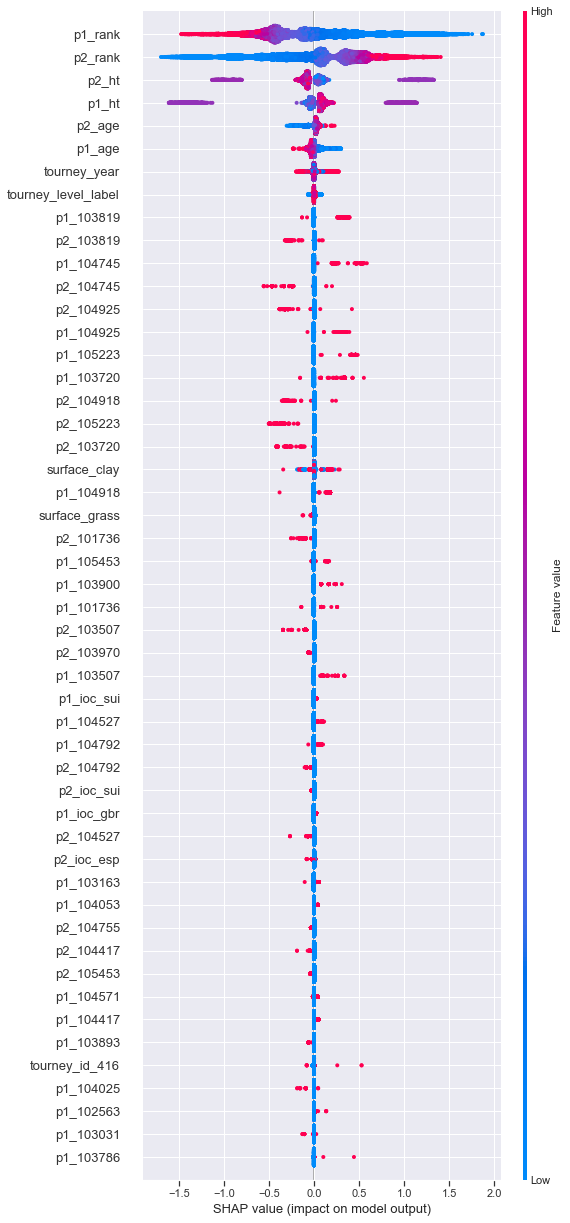

In [7]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mw.model, data=mw.X_train.values)
shap_values = explainer.shap_values(mw.X_test.values)
shap.summary_plot(shap_values, mw.X_test, max_display=50)

In [8]:
shap_df = pd.DataFrame(shap_values, columns=mw.X_test.columns)
shap_df.describe()

,tourney_level_label,tourney_year,p1_age,p1_ht,p1_rank,p2_age,p2_ht,p2_rank,best_of_3,best_of_5,...,tourney_id_m010,tourney_id_m014,tourney_id_m015,tourney_id_m016,tourney_id_m020,tourney_id_m021,tourney_id_m024,tourney_id_m035,tourney_id_m052,tourney_id_o16
count,29620.000000,29620.000000,29620.000000,29620.000000,29620.000000,29620.000000,29620.000000,29620.000000,29620.0,29620.0,...,29620.0,29620.0,29620.0,29620.0,29620.0,29620.0,29620.0,29620.0,29620.0,29620.0
mean,-0.000007,0.000721,-0.000505,0.008029,-0.010845,0.001737,-0.001042,0.007403,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.016890,0.031483,0.052903,0.291320,0.540640,0.054038,0.254902,0.535601,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-0.063110,-0.198202,-0.234690,-1.610842,-1.473506,-0.303004,-1.130914,-1.697434,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.005051,-0.008742,-0.032808,-0.032447,-0.434404,0.007062,-0.086674,-0.324332,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000016,-0.001174,-0.008245,0.059963,-0.070771,0.019261,-0.060852,0.071066,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.003299,0.005373,0.006604,0.085444,0.321154,0.029722,0.056302,0.416776,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.079842,0.272680,0.300078,1.142739,1.874173,0.228398,1.330106,1.405282,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
print(f'Last Finished: {datetime.now().strftime(DATE_FORMAT)}')

Last Finished: 2019-10-30 09:10
